In [1]:
from datasets import load_dataset

# Use streaming=True to avoid downloading the full dataset
dataset = load_dataset("gmongaras/Amazon-Reviews-2023", split="train", streaming=True)

# Take just the first 1000 samples for exploration
sample_dataset = dataset.take(1000)

Resolving data files:   0%|          | 0/150 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/150 [00:00<?, ?it/s]

In [2]:
def pretty_print_sample(sample, verbose=False):
    for key, value in sample.items():
        if verbose:
            print(f"{key:15} ({type(value).__name__}) -> {value}")
        else:
            print(f"{key:15} -> {value}")
    print("-" * 50)

In [3]:
# Print the structure of the dataset
i = 0
for sample in sample_dataset:
    pretty_print_sample(sample, verbose=True)
    i += 1
    if i >= 3:
        break

rating          (float) -> 5.0
title           (str) -> Such a lovely scent but not overpowering.
text            (str) -> This spray is really nice. It smells really good, goes on really fine, and does the trick. I will say it feels like you need a lot of it though to get the texture I want. I have a lot of hair, medium thickness. I am comparing to other brands with yucky chemicals so I'm gonna stick with this. Try it!
images          (list) -> []
asin            (str) -> B00YQ6X8EO
parent_asin     (str) -> B00YQ6X8EO
user_id         (str) -> AGKHLEW2SOWHNMFQIJGBECAF7INQ
timestamp       (int) -> 1588687728923
helpful_vote    (int) -> 0
verified_purchase (bool) -> True
--------------------------------------------------
rating          (float) -> 4.0
title           (str) -> Works great but smells a little weird.
text            (str) -> This product does what I need it to do, I just wish it was odorless or had a soft coconut smell. Having my head smell like an orange coffee is offputti

In [4]:
import pandas as pd

# Collect a sample for analysis
samples = []
for i, sample in enumerate(dataset):
    if i >= 100000:  # Take 10k samples
        break
    samples.append(sample)

# Convert to DataFrame for easier analysis
df = pd.DataFrame(samples)

rating
5.0    60574
4.0    13156
1.0    11042
3.0     9093
2.0     6135
Name: count, dtype: int64


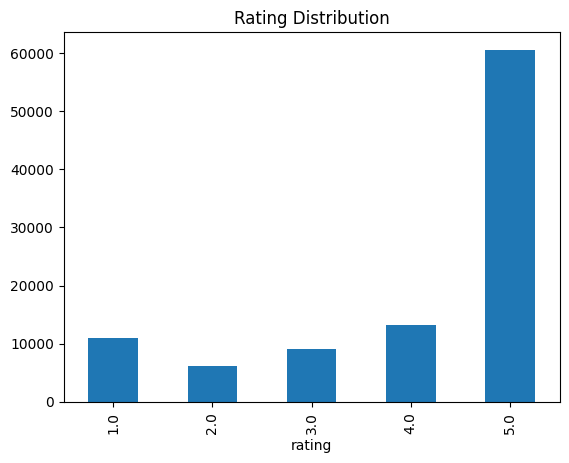

0        300
1        235
2         25
3         14
4          7
        ... 
99995     55
99996    632
99997    170
99998     18
99999     56
Name: text, Length: 100000, dtype: int64


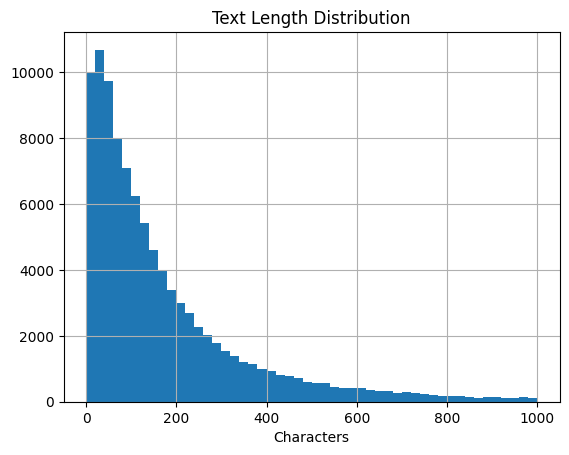

verified_purchase
True     87784
False    12216
Name: count, dtype: int64


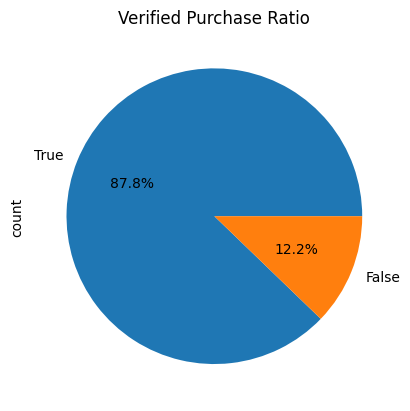

In [5]:
import matplotlib.pyplot as plt

# Rating distribution
print(df['rating'].value_counts())
df['rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Rating Distribution')
plt.show()

# Text length distribution
print(df['text'].str.len())
df['text'].str.len().hist(bins=50, range=(0, 1000))
plt.title('Text Length Distribution')
plt.xlabel('Characters')
plt.show()

# Verified purchase pie chart
print(df['verified_purchase'].value_counts())
df['verified_purchase'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Verified Purchase Ratio')
plt.show()

In [6]:
SENTIMENT_MAPPING = {
    0: 'negative',  # ratings 1-2
    1: 'neutral',   # rating 3
    2: 'positive'   # ratings 4-5
}

def clean_and_label_sample(sample):
    # Create sentiment label
    rating = sample['rating']
    if rating <= 2:
        sentiment = 0  # negative
    elif rating == 3:
        sentiment = 1  # neutral  
    else:
        sentiment = 2  # positive
    
    # Return cleaned sample with only needed fields
    return {
        'text': sample['text'],
        'title': sample['title'],
        'rating': sample['rating'],
        'sentiment': sentiment,
        'asin': sample['asin'],
        'parent_asin': sample['parent_asin'],
        'verified_purchase': sample['verified_purchase'],
        'helpful_vote': sample['helpful_vote']
    }

In [7]:
# Test on a few samples
for i, sample in enumerate(dataset):
    if i >= 3:  # Just test 3 samples
        break
    
    print(f"Original sample {i+1}:")
    pretty_print_sample(sample)
    
    cleaned = clean_and_label_sample(sample)
    print(f"Cleaned sample {i+1}:")
    pretty_print_sample(cleaned)
    print()

Original sample 1:
rating          -> 5.0
title           -> Such a lovely scent but not overpowering.
text            -> This spray is really nice. It smells really good, goes on really fine, and does the trick. I will say it feels like you need a lot of it though to get the texture I want. I have a lot of hair, medium thickness. I am comparing to other brands with yucky chemicals so I'm gonna stick with this. Try it!
images          -> []
asin            -> B00YQ6X8EO
parent_asin     -> B00YQ6X8EO
user_id         -> AGKHLEW2SOWHNMFQIJGBECAF7INQ
timestamp       -> 1588687728923
helpful_vote    -> 0
verified_purchase -> True
--------------------------------------------------
Cleaned sample 1:
text            -> This spray is really nice. It smells really good, goes on really fine, and does the trick. I will say it feels like you need a lot of it though to get the texture I want. I have a lot of hair, medium thickness. I am comparing to other brands with yucky chemicals so I'm gonna sti

In [8]:
# Process more samples (maybe 50k or 100k)
cleaned_samples = []
for i, sample in enumerate(dataset):
    if i >= 50000:  # Process 50k samples
        break
    cleaned = clean_and_label_sample(sample)
    cleaned_samples.append(cleaned)

print(f"Processed {len(cleaned_samples)} samples")

Processed 50000 samples


In [9]:
import pandas as pd

# Create DataFrame from cleaned samples
df_clean = pd.DataFrame(cleaned_samples)

# Check sentiment distribution
print("\nSentiment Distribution:")
sentiment_counts = df_clean['sentiment'].value_counts().sort_index()
print(sentiment_counts)

# Show percentages too
print("\nSentiment Percentages:")
sentiment_pct = df_clean['sentiment'].value_counts(normalize=True).sort_index() * 100
for sentiment, pct in sentiment_pct.items():
    label = SENTIMENT_MAPPING[sentiment]
    print(f"{sentiment} ({label}): {pct:.1f}%")


Sentiment Distribution:
sentiment
0     8368
1     4598
2    37034
Name: count, dtype: int64

Sentiment Percentages:
0 (negative): 16.7%
1 (neutral): 9.2%
2 (positive): 74.1%


In [1]:
from src.data_loader import load_streaming_dataset, save_processed_data, process_batch, create_splits, save_splits


# Process a larger batch for meaningful splits
dataset = load_streaming_dataset()
processed_batch = process_batch(dataset, batch_size=5000)

# Create splits
train, val, test = create_splits(processed_batch)

# Check the splits
print(f"Train: {len(train)}, Val: {len(val)}, Test: {len(test)}")
print("Sentiment distributions:")
for name, split in [("Train", train), ("Val", val), ("Test", test)]:
    dist = split['sentiment'].value_counts(normalize=True).sort_index()
    print(f"{name}: {dist.values}")

# Save splits
save_splits(train, val, test)

Resolving data files:   0%|          | 0/150 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/150 [00:00<?, ?it/s]

Train: 3500, Val: 750, Test: 750
Sentiment distributions:
Train: [0.12742857 0.1        0.77257143]
Val: [0.12666667 0.1        0.77333333]
Test: [0.12666667 0.1        0.77333333]
